# ფინალური პროექტი - Frozen Lake

პროექტი ეხება Reinforcement Learning-ის ერთ-ერთ კლასიკურ ამოცანას, სახელად: "Frozen Lake". 
ამოცანის გარემო აღებულია OpenAI-ს Gym-დან: https://www.gymlibrary.dev/environments/toy_text/frozen_lake/

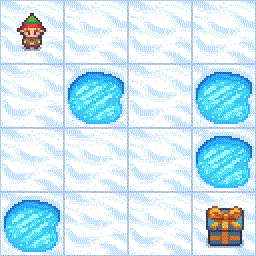

ამოცანის პირობა შემდგომია: აგენტმა უნდა მიაღწიოს საჩუქარს, ისე რომ წყალში არ ჩავარდეს.

თუ გარემოს შექმნისას gym.make() ფუნქციაში `is_slippery` არგუმენტს მოვნიშნავთ, როგორც `true`, მაშინ აგენტის მიერ გადადგმულ ნაბიჯს მიენიჭება 1/3 ალბათობა, ისევე როგორც ამ ნაბიჯის პერპენდიკულარულ მიმართულებებს:
თუ აგენტმა გადაწყვიტა წავიდეს `მარჯვნივ`:
P(Right) = 1/3
P(Up) = 1/3
P(Down) = 1/3

პრობლემის გადასაჭრელად გამოვიყენებ როგორც Q-Learning (https://en.wikipedia.org/wiki/Q-learning), ასევე Value Iteration (https://towardsdatascience.com/reinforcement-learning-an-easy-introduction-to-value-iteration-e4cfe0731fd5) ალგორითმებით.

In [25]:
# install gymnasium[toy-text]
!pip install gymnasium[toy-text]

import gymnasium as gym
import numpy as np # linear algebra
import random
from itertools import product

# imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from time import sleep

# ინიციალიზაცია

### შევქმნათ გარემო `gymnasium` ბიბლიოთეკის გამოყენებით:

In [26]:
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True)

### განვსაზღვროთ `action`-ებისა და `state`-ების განზომილებები, შექმნილი გარემოდან გამომდინარე:

In [28]:
N_STATES = env.observation_space.n
N_ACTIONS = env.action_space.n

### დავაინიციალიზოთ `NxM` განზომილების `Q-Table`, სადაც `N` არის `action`-ების განზომილება, ხოლო `M` - `state`-ების.

In [29]:
q_table = np.zeros((N_STATES, N_ACTIONS))
print(q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### განვსაზღვროთ `exploration_rate`-ის საზღვრები:

In [30]:
MAX_EXPLORATION_RATE = 1
MIN_EXPLORATION_RATE = 0.05

# `Q-Learning` ალგორითმი:

In [31]:
def train_q_learning(environement,
                     q_table,
                     learning_rate, 
                     discount_rate,
                     exploration_rate,
                     exploration_decay_rate,
                     N_EPS,
                     MAX_STEPS_PER_EP
                    ):
    exploration_rate = 1
    rewards = []
    for episode in range(N_EPS):
        state = environement.reset()[0]

        rewards_current_ep = 0

        for step in range(MAX_STEPS_PER_EP):
            sample_exploration = random.uniform(0, 1)
            if sample_exploration > exploration_rate:
                action = np.argmax(q_table[state, :])
            else:
                action = environement.action_space.sample()

            next_state, reward, terminated, truncated, _ = environement.step(action)
   
            q_table[state, action] = q_table[state, action] * (1 - learning_rate) + learning_rate * (reward + discount_rate * np.max(q_table[next_state, :]))

            state = next_state

            rewards_current_ep += reward

            if terminated or truncated:
                break

        exploration_rate = MIN_EXPLORATION_RATE + (MAX_EXPLORATION_RATE - MIN_EXPLORATION_RATE) * np.exp(-discount_rate * episode)

        rewards.append(rewards_current_ep)


    return rewards, q_table

# ავარჩიოთ `ჰიპერპატამეტრები`:

## ჰიპერპარამეტრების ტუნინგი (Grid Search):

### შევარჩიოთ საუკეთესო ჰიპერპარამეტრები შემდეგნაირად: ჰიპერპარამეტრები, რომლებიც საუკეთესო `avg_reward`-ს მოგვცემს, იქნება საუკეთესო

In [9]:
def tune_hyperparameters():
    learning_rates = [0.1, 0.2, 0.3]
    discount_rates = [0.95, 0.97, 0.99]
    exploration_decay_rates = [0.001, 0.0001]
    n_eps_values = [30_000, 50_000, 100_000]
    max_steps_values = [200, 300]

    result = None
    best_reward = float('-inf')
    best_rewards_arr = []

    i = 0
    for lr, dr, edr, n_eps, max_steps in product(learning_rates, discount_rates, exploration_decay_rates, n_eps_values, max_steps_values):
        print(i)
        q_table = np.zeros((N_STATES, N_ACTIONS))
        test_env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True)

        rewards, _ = train_q_learning(test_env, q_table, lr, dr, 1.0, edr, n_eps, max_steps)
        avg_reward = sum(rewards) / len(rewards)

        if avg_reward > best_reward:
            best_reward = avg_reward
            result = {
                'learning_rate': lr,
                'discount_rate': dr,
                'exploration_decay_rate': edr,
                'n_eps': n_eps,
                'max_steps': max_steps,
            }
            best_rewards_arr = rewards
        i += 1
    return best_rewards_arr, result

In [ ]:
top_result_rewards, result_hyperparameters = tune_hyperparameters()

## ავაგოთ ჰიპერპარამეტრების დიაგრამა `matplotlib` ბიბლიოთეკის გამოყენებით (`result_hyperparameters` ცვლადზე დაყრდნობით): 

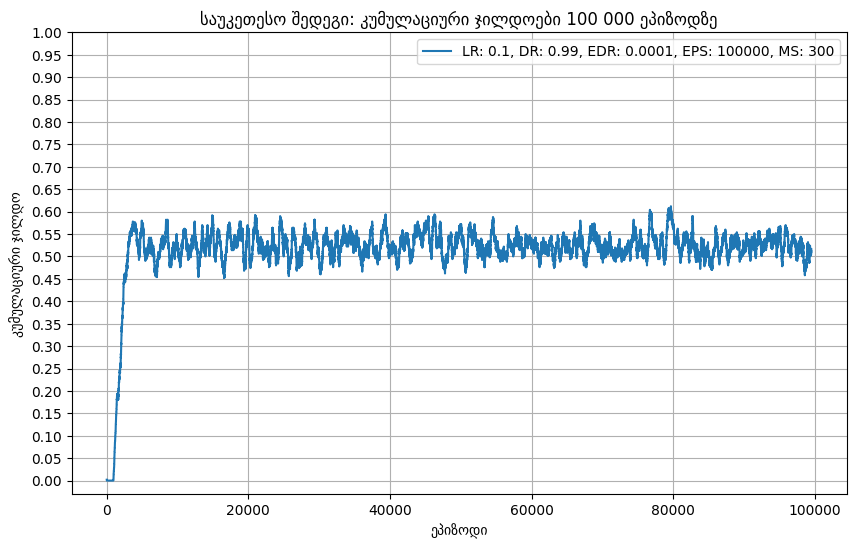

In [27]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 500

smoothed_rewards = moving_average(top_result_rewards, window_size)

y_ticks = np.arange(0, 1.05, 0.05)

plt.figure(figsize=(10, 6))

plt.plot(smoothed_rewards, label=f"LR: {result_hyperparameters['learning_rate']}, DR: {result_hyperparameters['discount_rate']}, EDR: {result_hyperparameters['exploration_decay_rate']}, EPS: {result_hyperparameters['n_eps']}, MS: {result_hyperparameters['max_steps']}")

num_episodes = result_hyperparameters['n_eps']
plt.title(f'საუკეთესო შედეგი: კუმულაციური ჯილდოები {num_episodes} ეპიზოდზე')
plt.xlabel('ეპიზოდი')
plt.ylabel('კუმულაციური ჯილდო')

plt.yticks(y_ticks)

plt.grid(True)
plt.legend()
plt.show()

### `ეპიზოდების რაოდენობა` - განსაზღვრავს თუ რამდენი ეპიზოდი აქვს აგენტს იმისათვის, რომ ისწავლოს. რაც უფრო დიდია ეპიზოდების რაოდენობა, აგენტი უფრო მეტ მდოგმარეობას გამოიკვლევს, თუმცა ასევე იზრდება გამოთვლების რაოდენობა და შესაბამისად დრო. 

In [32]:
N_EPS = result_hyperparameters['n_eps']

### `ნაბიჯების მაქსიმალური რაოდენობა` - განსაზღვრავს აგენტის ნაბიჯების მაქსიმალურ რაოდენობას თითოეული ეპიზოდის განმავლობაში.

In [33]:
MAX_STEPS_PER_EP = result_hyperparameters['max_steps']

## `Learning Rate`

In [34]:
learning_rate = result_hyperparameters['learning_rate']

## `Discount Rate`

### განსაზღვრავს, თუ როგორ შეეფარდება მომავალი ჯილდოები ახლანდელებს. მაღალი discount_rate-ის შემთხვევაში, აგენტი ისეთ გადაწყვეტილებებს მიიღებს, რომლებიც long-term-ში უფრო ხელსაყრელია.

In [35]:
discount_rate = result_hyperparameters['discount_rate']

## `Exploration Rate`

### exploration_rate თავიდან მაღალია (ჩვენ შემთხვევაში 1-ის ტოლი), რაც აგენტს უბიძგებს, რომ გარემო გამოიკვლიოს. ეს ცვლადი ნელ-ნელა კლებულობს, რათა შემდგომში აგენტმა უკვე ათვისებული ინფორმაცია გამოიყენოს (exploitation).

In [36]:
EXPLORATION_DECAY_RATE = result_hyperparameters['exploration_decay_rate']
exploration_rate = MAX_EXPLORATION_RATE

In [37]:
_, q_table_res = train_q_learning(
    env,
    q_table,
    learning_rate,
    discount_rate,
    exploration_rate,
    EXPLORATION_DECAY_RATE,
    N_EPS,
    MAX_STEPS_PER_EP
)

print(f"მიღებული Q-Table: {q_table_res}")

მიღებული Q-Table: [[0.53990533 0.50395514 0.50674328 0.50578747]
 [0.39474493 0.32795685 0.42691571 0.49379418]
 [0.45071122 0.45684167 0.41898615 0.46692851]
 [0.29774117 0.28709253 0.39792264 0.45269705]
 [0.55230999 0.45811434 0.28692684 0.38120481]
 [0.         0.         0.         0.        ]
 [0.25678064 0.18687848 0.31447449 0.13005598]
 [0.         0.         0.         0.        ]
 [0.42326998 0.37053204 0.32207114 0.58771504]
 [0.40115434 0.61387856 0.48607697 0.44005852]
 [0.59706906 0.43008113 0.48103363 0.35080668]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.53529277 0.65127193 0.71436913 0.48586277]
 [0.74453562 0.81119802 0.78661091 0.78977891]
 [0.         0.         0.         0.        ]]


### Q-Learning ალგორითმის ვიზუალიზაცია:

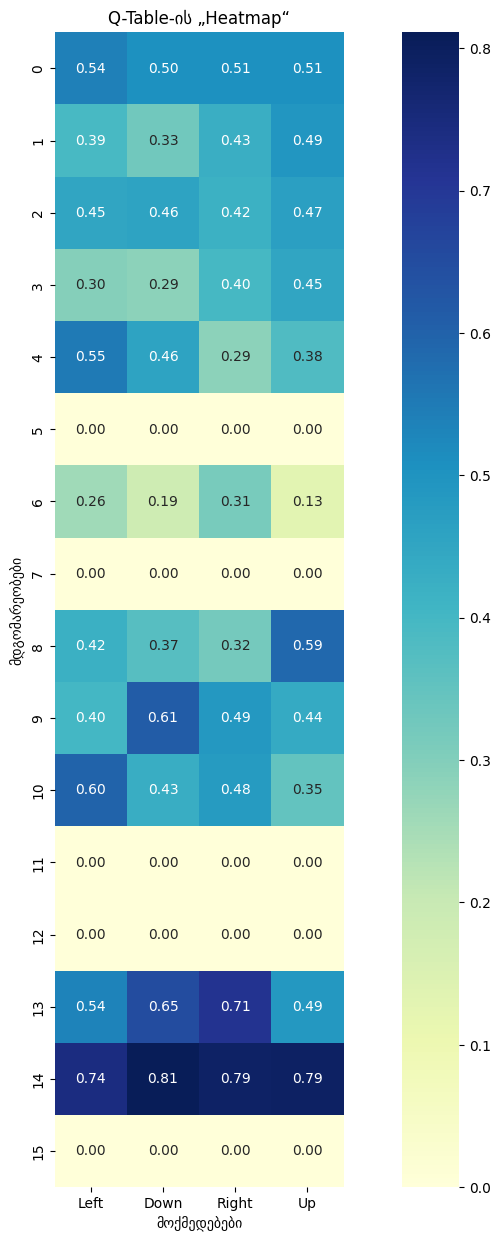

In [39]:
plt.figure(figsize=(15, 15))
sns.heatmap(q_table, annot=True, cmap="YlGnBu", cbar=True, square=True, fmt=".2f",
            xticklabels=['Left', 'Down', 'Right', 'Up'], yticklabels=np.arange(16))

plt.title(f"Q-Table-ის „Heatmap“")
plt.xlabel("მოქმედებები")
plt.ylabel("მდგომარეობები")
plt.show()

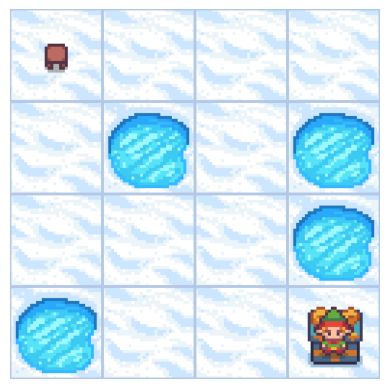

In [40]:
test_env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="rgb_array")
state = test_env.reset()[0]

while True:
    clear_output(wait=True)
    action = np.argmax(q_table_res[state, :])
    next_state, reward, terminated, truncated, _ = test_env.step(action)

    img = test_env.render()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    sleep(0.5)

    if terminated or truncated:
        break
    state = next_state

### ასევე ვნახოთ რამდენ შემთხვევაში აიღებს აგენტი ჯილდოს ალგორითმის 100_000-ჯერ გაშვების შემთხვევაში: 

In [44]:
num_eps = 100_000

def simulate_q(num_eps):
    test_env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="rgb_array")

    success_counts = np.zeros(num_eps)
    cumulative_successes = 0

    for ep in range(num_eps):
        state = test_env.reset()[0]

        while True:
            action = np.argmax(q_table_res[state, :])
            next_state, reward, terminated, truncated, _ = test_env.step(action)

            if reward == 1.0:
                cumulative_successes += 1

            if terminated or truncated:
                break
            state = next_state
        success_counts[ep] = cumulative_successes

    print(f"სტატისტიკა: {cumulative_successes} / {num_eps}")
    
    return success_counts
success_counts = simulate_q(num_eps)

სტატისტიკა: 74005 / 100000


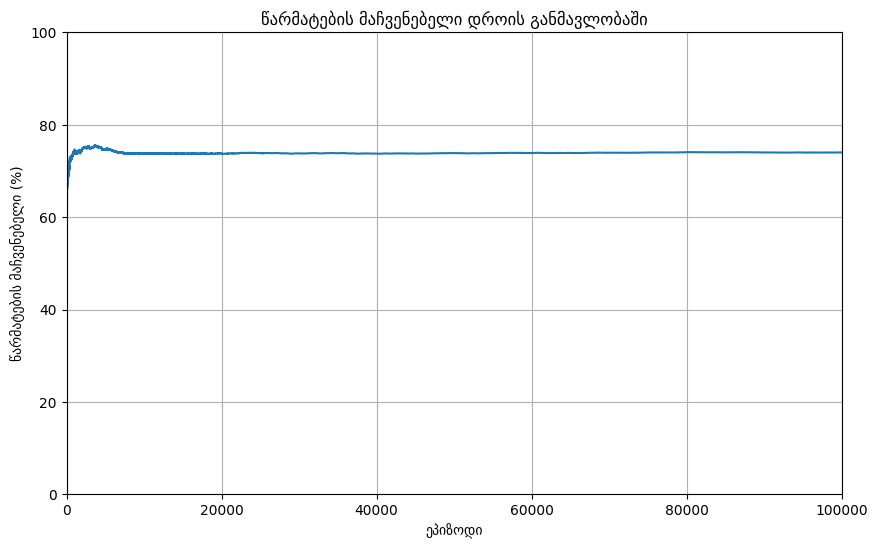

In [45]:
def graph_success_rate(success_counts):
    success_rate = success_counts / (np.arange(num_eps) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(success_rate * 100)
    plt.title("წარმატების მაჩვენებელი დროის განმავლობაში")
    plt.xlabel("ეპიზოდი")
    plt.ylabel("წარმატების მაჩვენებელი (%)")
    plt.grid(True)
    plt.xlim(0, num_eps)
    plt.ylim(0, 100)
    plt.show()
    
graph_success_rate(success_counts)

# `Value Iteration` ალგორითმი

### შევქმნათ `value_it_env`:

In [46]:
value_it_env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True)

N_VALUE_IT_STATES = value_it_env.observation_space.n
N_VALUE_IT_ACTIONS = value_it_env.action_space.n

### განვსაზღვროთ `value_table`:

In [47]:
value_table = np.zeros(N_VALUE_IT_STATES)

### `ჰიპერპარამეტრები`:

In [49]:
discount_rate = 0.99
theta = 1e-20

### `compute_action_values_with_given_state` - ითვლის მოცემული state-დან თითოეული action-ის წონას.

In [50]:
def compute_action_values_with_given_state(state, value_table):
    action_values = np.zeros(N_VALUE_IT_ACTIONS)
    for action in range(N_VALUE_IT_ACTIONS):
        for probability, next_state, reward, terminated in value_it_env.unwrapped.P[state][action]:
            future_reward = 0
            if not terminated:
                future_reward = discount_rate * value_table[next_state]
            expected_value = probability * (reward + future_reward)
            action_values[action] += expected_value
    return action_values

### `train_value_iteration` - Value Iteration ალგორითმი

In [51]:
def train_value_iteration():
    # delta-ს ცვლილების ვიზუალიზაციისთვის
    delta_values = []
    i = 0
    
    while True:
        delta = 0
        
        for state in range(N_VALUE_IT_STATES):
            action_values = compute_action_values_with_given_state(state, value_table)
            best_action_val = np.max(action_values)
            
            diff = np.abs(best_action_val - value_table[state])
            delta = max(delta, diff)
            
            value_table[state] = best_action_val
        
        delta_values.append(delta)
        i += 1
        
        if delta < theta:
            break
    return delta_values

In [52]:
delta_values_res = train_value_iteration()

### `Value Iteration` ალგორითმის ვიზუალიზაცია:

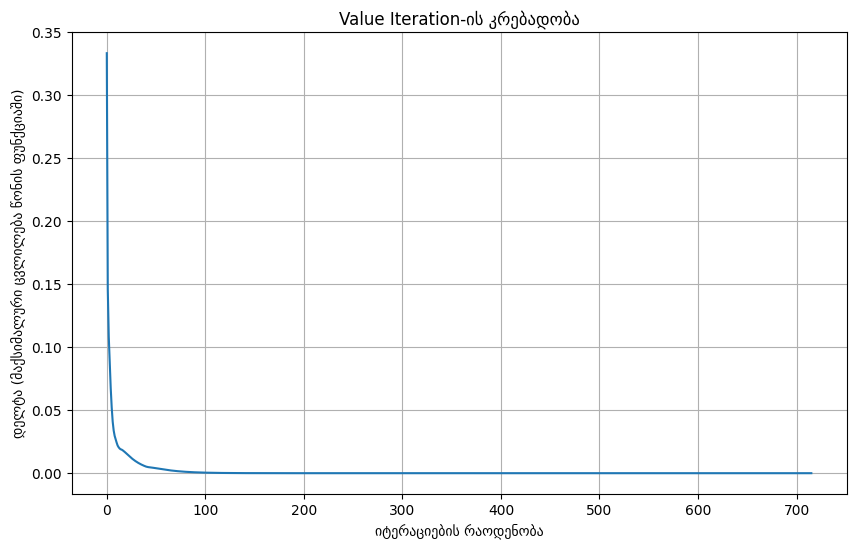

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(delta_values_res)
plt.title("Value Iteration-ის კრებადობა")
plt.xlabel("იტერაციების რაოდენობა")
plt.ylabel("დელტა (მაქსიმალური ცვლილება წონის ფუნქციაში)")
plt.grid(True)
plt.show()

#### შევადგინოთ ოპტიმალური policy ცხრილი:

In [54]:
policy_table = np.zeros(N_VALUE_IT_STATES, dtype=int)

for state in range(N_VALUE_IT_STATES):
    action_values = compute_action_values_with_given_state(state, value_table)
    policy_table[state] = np.argmax(action_values)

### დავბეჭდოთ ეს ცხრილი:

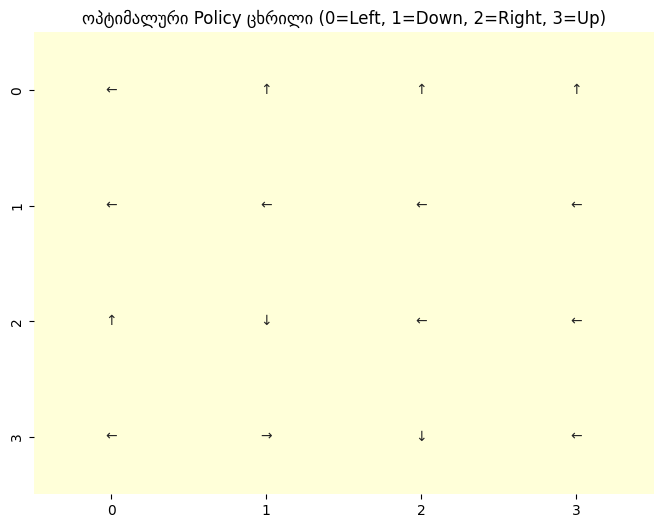

In [55]:
directions = np.array(["←", "↓", "→", "↑"])
policy_grid = directions[policy_table].reshape((4, 4))

plt.figure(figsize=(8, 6))
sns.heatmap(np.zeros_like(policy_grid, dtype=float), annot=policy_grid, fmt='', cmap="YlGnBu", cbar=False)
plt.title("ოპტიმალური Policy ცხრილი (0=Left, 1=Down, 2=Right, 3=Up)")
plt.show()

### დავბეჭდოთ ოპტიმალური `Value Table`:

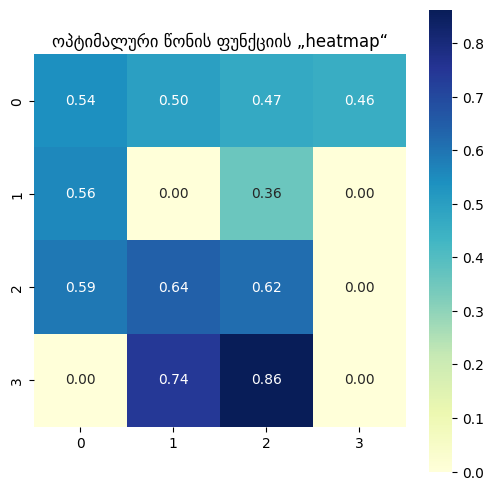

In [56]:
plt.figure(figsize=(6, 6))
sns.heatmap(value_table.reshape((4, 4)), annot=True, cmap="YlGnBu", cbar=True, square=True, fmt=".2f")
plt.title("ოპტიმალური წონის ფუნქციის „heatmap“")
plt.show()

### `Value Iteration` ალგორითმის უშუალო ვიზუალიზაცია:

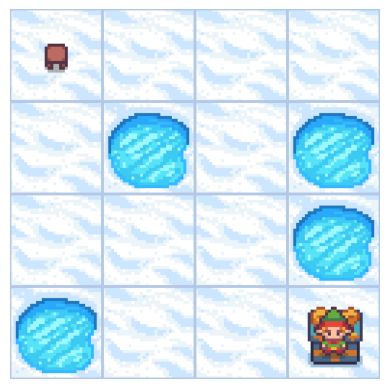

In [57]:
test_env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="rgb_array")

state = test_env.reset()[0]
while True:
    clear_output(wait=True)
    
    action = policy_table[state]
    next_state, reward, terminated, truncated, _ = test_env.step(action)
    
    sleep(0.5)
    img = test_env.render()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    state = next_state
    
    if terminated or truncated:
        break

### ასევე ვნახოთ რამდენ შემთხვევაში აიღებს აგენტი ჯილდოს ალგორითმის 100_000-ჯერ გაშვების შემთხვევაში: 

In [59]:
num_eps = 100_000

def simulate_value_iteration(num_eps):
    test_env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="rgb_array")

    success_counts = np.zeros(num_eps)
    cumulative_successes = 0
    for ep in range(num_eps):
        state = test_env.reset()[0]
        while True:
            action = policy_table[state]
            next_state, reward, terminated, truncated, _ = test_env.step(action)

            state = next_state

            if reward == 1.0:
                cumulative_successes += 1

            if terminated or truncated:
                break
        success_counts[ep] = cumulative_successes

    print(f"სტატისტიკა: {cumulative_successes} / {num_eps}")
    
    return success_counts
success_counts = simulate_value_iteration(num_eps)

სტატისტიკა: 73855 / 100000


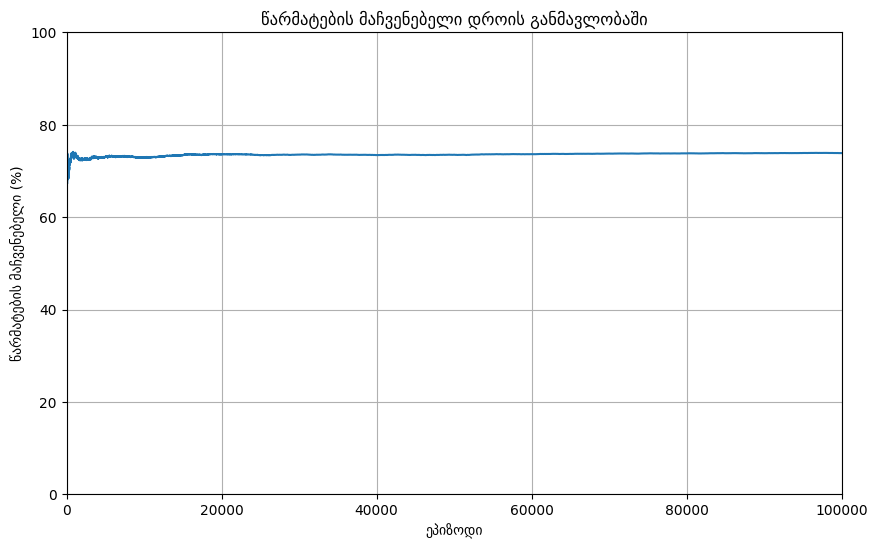

In [60]:
graph_success_rate(success_counts)